# NBV Classification

In this notebook I train and validate the 3D CNN proposed by Mendoza et al. for Next Best View planning.

J. Irving Vasquez-Gomez
jivg.org

If our are using this code in your project please cite our paper:

> Mendoza, M., Vasquez-Gomez, J. I., Taud, H., Sucar, L. E., & Reta, C. (2019). Supervised Learning of the Next-Best-View for 3D Object Reconstruction. arXiv preprint arXiv:1905.05833.

In [ ]:
# notebook configuration
display_dataset = True
display_fwd_pretraining = True
load_weights = False
reading_weights_file = 'weights/paper_param.pth'
saving_weights_file = 'log/weights.pth'
epochs = 1000
batch_size = 200
learning_rate = 0.001
dropout_prob= 0.0

In [ ]:
import numpy as np
import csv

import classification_nbv as cnbv
import nbvnet

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.nn as nn
from torch import optim

from torch.autograd import Variable

In [ ]:
#check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

In [ ]:
# save parameters used
params = {'epochs': epochs, 'batch_size': 200, 'learning_rate': learning_rate, 'dropout_prob': dropout_prob}
#print(params)

with open("log/parameters.csv", 'w') as csvfile:
    fieldnames = params.keys()  #['first_name', 'last_name', 'Grade']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
 
    writer.writeheader()
    writer.writerow(params)

## Dataset Preprocessing

In [ ]:
# Read the pose that corresponds to a class.
nbv_positions = np.genfromtxt('points_in_sphere.txt')

# This function converts a class to its corresponding pose
def getPosition(nbv_class, nbv_positions):
    return nbv_positions[nbv_class]
            

In [ ]:
training_dataset = cnbv.NBVClassificationDatasetFull(grid_file='../dataset/classification/training/dataset_vol_classification_training.npy', 
                                    nbv_class_file='../dataset/classification/training/dataset_lbl_classification_training.npy',
                                    transform=transforms.Compose([
                                    # Reshapes the plain grid
                                    cnbv.To3DGrid(),
                                    #converts to tensors
                                    cnbv.ToTensor()
                                    ]))

validation_dataset = cnbv.NBVClassificationDatasetFull(grid_file='../dataset/classification/validation/dataset_vol_classification_validation.npy', 
                                    nbv_class_file='../dataset/classification/validation/dataset_lbl_classification_validation.npy',
                                    transform=transforms.Compose([
                                    # Reshapes the plain grid
                                    cnbv.To3DGrid(),
                                    #converts to tensors
                                    cnbv.ToTensor()
                                    ]))

   

In [ ]:
print('Training dataset lenght:' + str(len(training_dataset)))
print('Validation dataset lenght:' + str(len(validation_dataset)))

for i in range(len(training_dataset)):
    sample = training_dataset[i]

    print(i, sample['grid'].size(), sample['nbv_class'].size())
    
    if display_dataset:
        #print(sample['nbv_class'].numpy())
        nbv = getPosition(sample['nbv_class'].numpy(), nbv_positions)
        nbv = np.squeeze(nbv)
        #print(nbv)
        cnbv.showGrid(sample['grid'].numpy(), nbv)
    
    if i == 3:
        break

In [ ]:
# load training data in batches
#batch_size = 500

train_loader = DataLoader(training_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

validation_loader = DataLoader(validation_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## NBV-Net

NBV net:

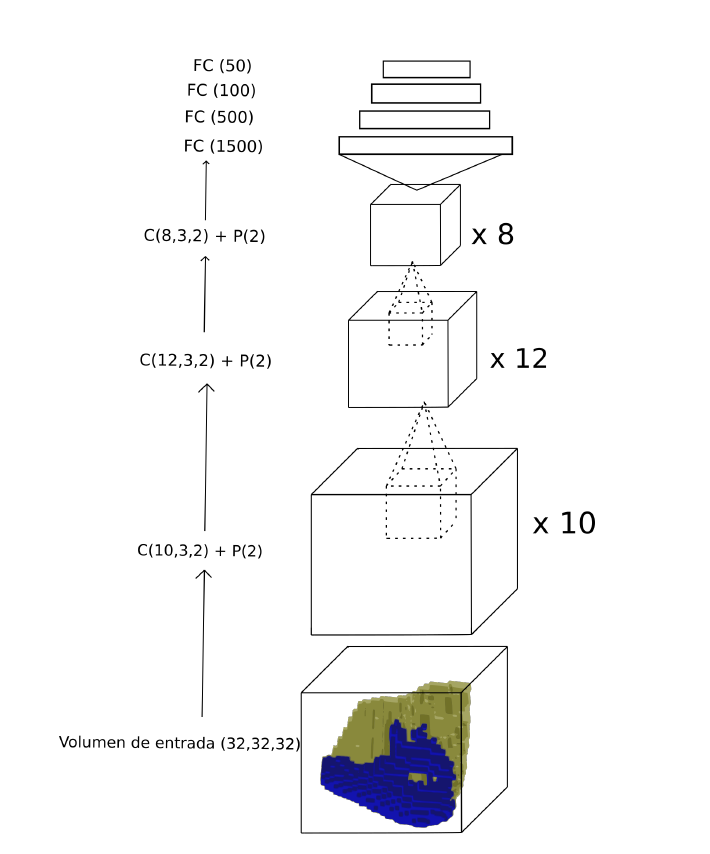

In [ ]:
net = nbvnet.NBV_Net(dropout_prob)
net.to(device)
print(net)

In [ ]:
# Weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        m.weight.data.normal_(0.0, 0.1)
        m.bias.data.fill_(0)
        
net.apply(weights_init)

In [ ]:
# weights load
if load_weights:
    state_dict = torch.load(reading_weights_file)
    #print(state_dict.keys())
    net.load_state_dict(state_dict)

In [ ]:
# test the model on a batch of test grids
def net_sample_output():
    net.eval()
    
    # iterate through the test dataset
    for i, sample in enumerate(train_loader):
        
        # get sample data: images and ground truth keypoints
        grids = sample['grid']
        nbvs = sample['nbv_class']

        # convert images to FloatTensors
        grids = grids.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        grids = Variable(grids)    
        grids = grids.to(device)

        # forward pass to get net output
        output = net(grids)
        grids = grids.cpu()
        output = output.cpu()
        
        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(output.data, 1)

        # break after first image is tested
        if i == 0:
            return grids, predicted, nbvs

In [ ]:
# call the function that test the model on a batch
# returns: test images, test predicted keypoints, test ground truth keypoints
test_grids, test_outputs, gt_nbvs = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_grids.data.size())
print(test_outputs.data.size())
#print(test_outputs)
print(gt_nbvs.size())
#print(gt_nbvs)

In [ ]:
# helpful function that displays the octree and the nbv
def visualize_output(test_grids, test_outputs, gt_nbvs=None, batch_size=batch_size):

    for i in range(batch_size):
        #plt.figure(figsize=(20,10))
        #ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        grid = test_grids[i].data   # get the image from it's wrapper
        grid = grid.numpy()   # convert to numpy array from a Tensor
        #image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        print(test_outputs[i].data.numpy())
        # un-transform the predicted nbv
        #angles = test_outputs[i].data.numpy()
        #angles = lnbv.normPos2Angles(angles)
        #yaw, pitch = angles
        #r = 0.4      
        predicted = getPosition( test_outputs[i].data.numpy(), nbv_positions)
        #print(predicted)
        
        print(gt_nbvs[i].numpy())
        #gt_angles = gt_nbvs[i].numpy()
        #gt_angles = lnbv.normPos2Angles(gt_angles)
        #gt_yaw, gt_pitch = gt_angles
        #print(np.array([r, gt_yaw, gt_pitch]))
        gt = getPosition(gt_nbvs[i].numpy(), nbv_positions)
        #print(gt)
        
        cnbv.showGrid(grid, gt, predicted)

        #plt.show()
        
        if i==2:
            break

In [ ]:
visualize_output(test_grids, test_outputs, np.squeeze(gt_nbvs))

## Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= learning_rate)

In [ ]:
# Validation Function
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for sample in testloader:
        
        # get sample data: images and ground truth keypoints
        grids = sample['grid']
        nbvs = sample['nbv_class']
        
        # convert images to FloatTensors
        grids = grids.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        grids = Variable(grids)    
        grids = grids.to(device)
        
        # wrap them in a torch Variable
        nbvs = Variable(nbvs) 
        nbvs = nbvs.to(device)

        output = model.forward(grids)
        test_loss += criterion(output, nbvs).item()

        # for log.  ps = torch.exp(output)
        equality = (nbvs.data == output.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [ ]:
# Training loop
#epochs = 10
running_loss = 0
save_after = 100

history_epoch = []
history_train_loss = []
history_validation_loss = []
history_train_accuracy = []
history_validation_accuracy = []

import time
tic = time.clock()

for e in range(epochs):
    # Cambiamos a modo entrenamiento
    net.train()
    
    for i, sample in enumerate(train_loader):        
        # get sample data: images and ground truth keypoints
        grids = sample['grid']
        nbvs = sample['nbv_class']

        # convert grids to FloatTensors
        grids = grids.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        grids = Variable(grids)    
        grids = grids.to(device)
        
        # wrap them in a torch Variable
        nbvs = Variable(nbvs) 
        nbvs = nbvs.to(device)
        
        optimizer.zero_grad()

        # forward pass to get net output
        output = net(grids)
        
        #ot = output.cpu()
        #print(ot)    
        
        loss = criterion(output, nbvs)
        # Backpropagation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
            
    
    # Cambiamos a modo de evaluación
    net.eval()
            
    # Apagamos los gradientes, reduce memoria y cálculos
    with torch.no_grad():
        train_loss, train_accuracy = validation(net, train_loader, criterion)
        val_loss, val_accuracy = validation(net, validation_loader, criterion)
        
        train_loss, train_accuracy = train_loss, train_accuracy.cpu().numpy()
        val_loss, val_accuracy = val_loss, val_accuracy.cpu().numpy()
        
        train_accuracy = train_accuracy / len(train_loader)
        val_accuracy = val_accuracy / len(validation_loader)
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Val. Loss: {:.3f}.. ".format(val_loss),
              "Train Accuracy: {:.3f}".format(train_accuracy),
              "Val. Accuracy: {:.3f}".format(val_accuracy))
    
    history_epoch.append(e)
    history_train_loss.append(train_loss)
    history_validation_loss.append(val_loss)
    history_train_accuracy.append(train_accuracy)
    history_validation_accuracy.append(val_accuracy)
    
    running_loss = 0
    
    if(e % save_after == 0):
        np.save('log/train_loss', history_train_loss)
        np.save('log/validation_loss', history_validation_loss)
        np.save('log/train_accuracy', history_train_accuracy)
        np.save('log/validation_accuracy', history_validation_accuracy)
        torch.save(net.state_dict(), 'log/weights.pth')
    
    # Make sure training is back on
    net.train()
    
toc = time.clock()
print(toc - tic)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_epoch, history_train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.savefig('log/train_loss.png')
plt.show()

plt.plot(history_epoch, history_train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train set accuracy')
plt.savefig('log/train_accuracy.png')
plt.show()

plt.plot(history_epoch, history_validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation set accuracy')
plt.savefig('log/validation_accuracy.png')
plt.show()

# Test network

In [ ]:
# returns: test images, test predicted keypoints, test ground truth keypoints
test_grids, test_outputs, gt_nbvs = net_sample_output()
visualize_output(test_grids, test_outputs, np.squeeze(gt_nbvs))

In [ ]:
# save parameters
torch.save(net.state_dict(), saving_weights_file)

In [ ]:
# save metrics

np.save('log/train_loss', history_train_loss)
np.save('log/validation_loss', history_validation_loss)
np.save('log/train_accuracy', history_train_accuracy)
np.save('log/validation_accuracy', history_validation_accuracy)